In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

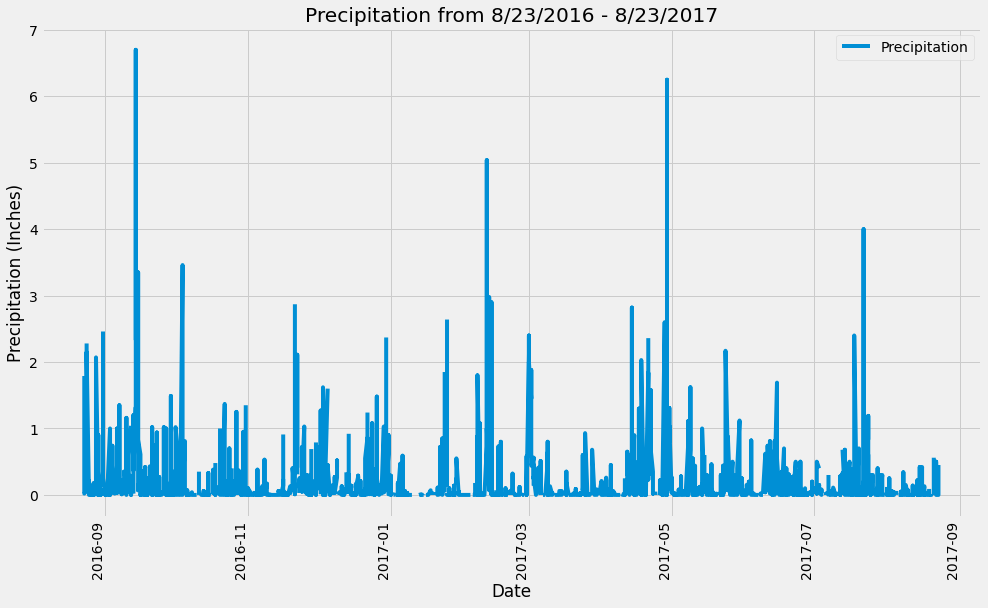

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
# Calculate the date one year from the last date in data set.
year = dt.date(2017,8,23) - dt.timedelta(days=365)
year

# Perform a query to retrieve the data and precipitation scores
p_year = session.query(measurement.date, (measurement.prcp)).\
                filter(measurement.date >= year).all()
p_year

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(p_year, columns=['Date', 'Precipitation'])
precipitation['Date'] = pd.to_datetime(precipitation['Date'])

# Sort the dataframe by date
precipitation_sorted = precipitation.sort_values(by=['Date'])
precipitation_sorted.dtypes

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_sorted.plot(x='Date', y='Precipitation', rot=90, figsize=(15,10))

plt.title("Precipitation from 8/23/2016 - 8/23/2017")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df = precipitation.describe()
df

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(measurement.station).distinct().count()
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [15]:
temps_df=pd.DataFrame(temps, columns=['Min','Max', 'Avg'])
temps_df

Min   Max        Avg
0  54.0  85.0  71.663781

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_one_year = dt.date(2017,8,23) - dt.timedelta(days=365)
most_active_temp = session.query(measurement.date, measurement.tobs).\
                            filter(measurement.station == 'USC00519281').\
                            filter(measurement.date>=most_active_one_year)

most_active_temp_df=pd.DataFrame(most_active_temp, columns=['Date','Temperature'])
most_active_temp_df

Date  Temperature
0    2016-08-23         77.0
1    2016-08-24         77.0
2    2016-08-25         80.0
3    2016-08-26         80.0
4    2016-08-27         75.0
..          ...          ...
347  2017-08-14         77.0
348  2017-08-15         77.0
349  2017-08-16         76.0
350  2017-08-17         76.0
351  2017-08-18         79.0

[352 rows x 2 columns]

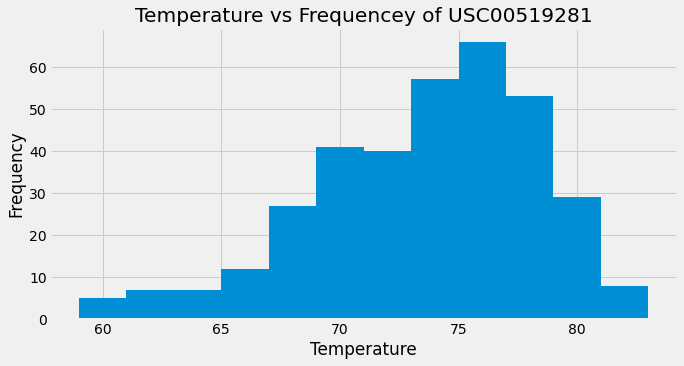

In [17]:
# Plot the results as a histogram
temp_hist = most_active_temp_df.hist(bins=12, figsize=(10,5))

# Label x, y, and title
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("Temperature vs Frequencey of USC00519281")

# Show histogram
plt.show()

# Close session

In [18]:
# Close Session
session.close()